# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [2]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env(".env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

OPENAI_API_KEY=****lj8A
GROQ_API_KEY=****XG6b
LANGSMITH_API_KEY=****c376
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
Python 3.13.7 satisfies requires-python: >=3.11,<3.14
package                | required | installed | status | path                                                                    
---------------------- | -------- | --------- | ------ | ------------------------------------------------------------------------
langgraph              | >=1.0.0  | 1.0.5     | ✅ OK   | c:\Users\nilad\AppData\Local\Programs\Python\Python313\Lib\site-packages
langchain              | >=1.0.0  | 1.2.3     | ✅ OK   | c:\Users\nilad\AppData\Local\Programs\Python\Python313\Lib\site-packages
langchain-core         | >=1.0.0  | 1.2.7     | ✅ OK   | c:\Users\nilad\AppData\Local\Programs\Python\Python313\Lib\site-packages
langchain-openai       | >=1.0.0  | 1.1.7     | ✅ OK   | c:\Users\nilad\AppData\Local\Programs\Python\Python313\Lib\site-packages
langchain-anthropic    | >=1.0.0  | 1.3.1  

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# Verify it works
print(db.get_usable_table_names())

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


Define the runtime context to provide the agent and tools with access to the database.

In [4]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [5]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [6]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [7]:
from langchain.agents import create_agent
from langchain_groq import ChatGroq

""" agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
) """

# Initialize the Groq model
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_retries=2,
)

# Use the llm object in the agent creation
agent = create_agent(
    model=llm, 
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

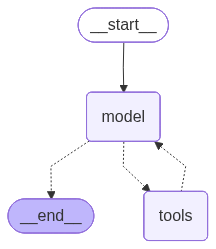

In [8]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [9]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_bff6e603-45ab-407e-b39a-38a61d59e668)
 Call ID: fc_bff6e603-45ab-407e-b39a-38a61d59e668
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_b2554901-fcd5-49ab-a9e9-807dc9d3c658)
 Call ID: fc_b2554901-fcd5-49ab-a9e9-807dc9d3c658
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS cnt FROM Album UNION ALL SELECT 'Artist', COUNT(*) FROM Artist UN

In [10]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_e330727c-833f-4052-907b-6660502bcaea)
 Call ID: fc_e330727c-833f-4052-907b-6660502bcaea
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_5c30a25a-e49c-4e91-96a0-cd72adef290d)
 Call ID: fc_5c30a25a-e49c-4e91-96a0-cd72adef290d
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('

In [11]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_50d3685c-fba0-475a-85c7-ea1fa7faa77e)
 Call ID: fc_50d3685c-fba0-475a-85c7-ea1fa7faa77e
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are the tables in the database:

- Album  
- Artist  
- Customer  
- Employee  
- Genre  
- Invoice  
- InvoiceLine  
- MediaType  
- Playlist  
- PlaylistTrack  
- Track


**Create your own query here!**  Add some questions of your own.

In [12]:
question = "TRY YOUR OWN QUERY HERE"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

TRY YOUR OWN QUERY HERE
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_fcdb449c-4773-4829-abf4-1215ac8d7f20)
 Call ID: fc_fcdb449c-4773-4829-abf4-1215ac8d7f20
  Args:
    query: SELECT name, sql FROM sqlite_master WHERE type='table' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album', 'CREATE TABLE [Album]\n(\n    [AlbumId] INTEGER  NOT NULL,\n    [Title] NVARCHAR(160)  NOT NULL,\n    [ArtistId] INTEGER  NOT NULL,\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)'), ('Artist', 'CREATE TABLE [Artist]\n(\n    [ArtistId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(120),\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\n)'), ('Customer', 'CREATE TABLE [Customer]\n(\n

### Let's try this Studio